In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import joblib
import pretty_midi
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from MIDIComposingAI.get_back_data import melody_to_piano_roll, assembled_target_to_melody, assemblate_accompaniment_melody
from MIDIComposingAI.utils import piano_roll_to_pretty_midi
from MIDIComposingAI.create_dataset import separate_pitch_velocity, create_classified_melody
import visual_midi

2021-12-02 22:29:59.415567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 22:29:59.415659: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Getting data

## Simple dataset

In [2]:
X, y_pitch, y_velocity = joblib.load(f'../raw_data/pandas_dataframes/simple_dataset/nparray0')
for i in range(1, 10):
    loaded = joblib.load(f'../raw_data/pandas_dataframes/simple_dataset/nparray{i}')
    X = np.concatenate((X, loaded[0]))
    y_pitch = np.concatenate((y_pitch, loaded[1]))
    y_velocity = np.concatenate((y_velocity, loaded[2]))
    print(f'{i} done')

1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done


In [3]:
X.shape

(77, 500, 128)

In [4]:
X_train, X_test, y_pitch_train, y_pitch_test, y_velocity_train, y_velocity_test = train_test_split(X, y_pitch, y_velocity, test_size=0.3)

## Bigger Dataset

In [6]:
X, y_pitch, y_velocity = joblib.load(f'../raw_data/pandas_dataframes/bigger_dataset/nparray0')

In [8]:
for i in range(1, 50):
    loaded = joblib.load(f'../raw_data/pandas_dataframes/bigger_dataset/nparray{i}')
    X = np.concatenate((X, loaded[0]))
    y_pitch = np.concatenate((y_pitch, loaded[1]))
    y_velocity = np.concatenate((y_velocity, loaded[2]))

In [9]:
X_train, X_test, y_pitch_train, y_pitch_test, y_velocity_train, y_velocity_test = train_test_split(X, y_pitch, y_velocity, test_size=0.3)

In [11]:
X.shape

(363, 500, 128)

In [10]:
for test in X:
    if test.max() > 127:
        print(f'error : {test.max()}')

error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 194.0
error : 194.0
error : 208.0
error : 191.0
error : 206.0
error : 205.0
error : 201.0
error : 206.0
error : 208.0
error : 209.0
error : 211.0
error : 200.0
error : 158.0
error : 164.0
error : 158.0
error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 200.0
error : 254.0
error : 254.0
error : 210.0
error : 210.0
error : 190.0
error : 190.0
error : 210.0
error : 210.0
error : 190.0
error : 190.0
error : 140.0
error : 140.0
error : 194.0
error : 182.0
error : 177.0
error : 180.0
error : 184.0
error : 210.0
error : 181.0
error : 210.0
error : 176.0
error : 197.0
error : 185.0
error : 129.0
error : 130.0
error : 130.0
error : 146.0
error : 191.0
error : 203.0
error : 203.0
error : 203.0
error : 201.0
error : 200.0
error : 247.0
error : 247.0
error : 247.0
error : 247.0
error : 247.0
error : 240.0
error 

## Simpler Dataset

In [2]:
X, y_pitch, y_velocity = joblib.load(f'../raw_data/pandas_dataframes/simple_dataset/nparray0')
for i in range(1, 10):
    loaded = joblib.load(f'../raw_data/pandas_dataframes/simple_dataset/nparray{i}')
    X = np.concatenate((X, loaded[0]))
    y_pitch = np.concatenate((y_pitch, loaded[1]))
    y_velocity = np.concatenate((y_velocity, loaded[2]))

X_train, X_test, y_pitch_train, y_pitch_test, y_velocity_train, y_velocity_test = train_test_split(X, y_pitch, y_velocity, test_size=0.3)

## Tuples targets dataset

In [2]:
X, y = joblib.load(f'../raw_data/pandas_dataframes/tuples_targets_dataset/sample0')
for i in range(1, 10):
    loaded = joblib.load(f'../raw_data/pandas_dataframes/tuples_targets_dataset/sample{i}')
    X = np.concatenate((X, loaded[0]))
    y = np.concatenate((y, loaded[1]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Testing DL models

## LSTM - Classic - Regression

In [38]:
inputs = layers.Input(shape=(500, 128)) # TO BE MODIFIED - SPARSE MATRIX  #input shape 128 * 10_000

# Envoi d'un sparse tensor sinon sparse matrix
# Envoyer en input sparse ou brut est-ce que ça change les perfs ou non
# https://stackoverflow.com/questions/20459536/convert-pandas-dataframe-to-sparse-numpy-matrix-directly

main_branch = layers.Masking(mask_value=0)(inputs)
main_branch = layers.LSTM(units=128, activation='tanh', return_sequences=True)(main_branch)
main_branch = layers.LSTM(units=128, activation='tanh')(main_branch)
main_branch = layers.Dense(64, activation='relu')(main_branch)
# DO WE NEED TWO LAYERS FOR REGRESSION AS WELL ?
pitch_branch = layers.Dense(500, activation='relu', name='pitch_output')(main_branch)
velocity_branch = layers.Dense(500, activation='relu', name='velocity_output')(main_branch)

model_lstm_reg = models.Model(inputs = inputs, outputs = [pitch_branch, velocity_branch])

In [39]:
model_lstm_reg.compile(loss='mse', optimizer='rmsprop') # LOSS TO REVIEW

In [40]:
model_lstm_reg.fit(X_train,
              {'pitch_output': y_pitch_train, 'velocity_output': y_velocity_train},
              epochs=3,
              batch_size=8,
              verbose=1,
              validation_split=0.2,
             )

Epoch 1/3
6/6 [==============================] - 14s 1s/step - loss: 9706.4238 - pitch_output_loss: 3175.2544 - velocity_output_loss: 6531.1694 - val_loss: 10705.6494 - val_pitch_output_loss: 3243.4358 - val_velocity_output_loss: 7462.2129
Epoch 2/3
6/6 [==============================] - 5s 779ms/step - loss: 9401.3330 - pitch_output_loss: 3048.1240 - velocity_output_loss: 6353.2085 - val_loss: 10031.0908 - val_pitch_output_loss: 2971.9373 - val_velocity_output_loss: 7059.1533
Epoch 3/3
6/6 [==============================] - 5s 792ms/step - loss: 8691.8584 - pitch_output_loss: 2756.4509 - velocity_output_loss: 5935.4072 - val_loss: 9142.1377 - val_pitch_output_loss: 2628.4707 - val_velocity_output_loss: 6513.6670


In [41]:
to_predict = joblib.load('../raw_data/pandas_dataframes/bigger_dataset/nparray28')[0]
true_pitches = joblib.load('../raw_data/pandas_dataframes/bigger_dataset/nparray28')[1]
true_velocities = joblib.load('../raw_data/pandas_dataframes/bigger_dataset/nparray28')[2]

In [42]:
to_predict[0].shape

(500, 128)

In [43]:
predictions = model_lstm_reg.predict(to_predict)

In [44]:
len(predictions), predictions[0].shape, predictions[1].shape

(2, (12, 500), (12, 500))

In [46]:
for i in range(12):
    print(f'prediction {i+1}')
    print(predictions[1][i])
    print(predictions[1][i].mean())
    print(f'true velocities {i+1}')
    print(true_velocities[i])

prediction 1
[ 0.         14.448837    8.772736    9.175815    7.1733527  11.563968
  9.174725    7.375934    0.          9.766924    9.374606    0.
  5.6858253   8.308912    9.691753    7.6841984  11.738454    9.960739
 13.725515    5.804236    8.772683    7.2288494   0.          6.548243
  9.436388    8.912844   12.319378   11.77016     0.         10.378804
  5.3871584   7.7704754   9.303396    7.637772    3.3219347   6.295297
  8.808726    8.796823    9.508945    6.831757    8.321323    7.7743936
  9.778733   11.111731    8.629077    8.5852995   4.5612407   8.771295
  6.540793    9.7514925   9.708191    9.524297    0.          0.
  8.540388    9.536207    8.168704    9.366955   10.001665    7.9070773
  0.         10.637432    8.469469    7.7779965   7.8657618   9.719302
  0.          9.921306    7.670378    8.018879    0.          6.534943
  8.691263    7.393707    7.7114363  12.972172    7.103353    7.417578
 13.359323   10.092494    8.562441    5.247567    0.          7.473106
  0

In [ ]:
def piano_roll_from_targets(pitches, velocities):
    
    piano_roll = np.array()
    for pitch in pitches:
        piano_roll[int(pitch)]

## Biderectional

In [21]:
inputs = layers.Input(shape=(128, 10_000), name='main_input') # TO BE MODIFIED - SPARSE MATRIX
# Add 2 bidirectional LSTMs
main_branch = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(main_branch)
main_branch = layers.Bidirectional(layers.LSTM(64))(main_branch)
# DO WE NEED TWO LAYERS FOR REGRESSION AS WELL ?
pitch_branch = layers.Dense(1, activation='linear', name='pitch_output')(main_branch)
velocity_branch = layers.Dense(1, activation='linear', name='velocity_output')(main_branch)
model_lstm_bin_reg = models.Model(inputs = inputs, outputs = [pitch_branch, velocity_branch])
model_lstm_bin_reg.summary()

ValueError: Input 0 of layer "bidirectional_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)

# Testing ML Random Forests

### Decision Tree Regressor

#### Test with one target shape (128, 500)
🤔 Not conclusive

In [97]:
X_train = X_train.reshape(X_train.shape[0], -1)

In [98]:
y_train = y_train.reshape(y_train.shape[0], -1)

In [99]:
tree = DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=2)

In [100]:
tree.fit(X_train, y_train)

ValueError: Number of labels=51 does not match number of samples=254

In [8]:
y_pred = tree.predict(X_test[2].reshape(1, -1))
y_pred = y_pred.reshape(128, -1)

In [12]:
pretty_melody = piano_roll_to_pretty_midi(y_pred)

In [25]:
coloring = visual_midi.presets.Coloring.INSTRUMENT
plotter = visual_midi.Plotter(coloring=coloring)
plotter.show_notebook(pretty_melody)

Loading BokehJS ...

Column(id='3849', ...)

In [83]:
y_pitch_train[0].shape

(500,)

<AxesSubplot:>

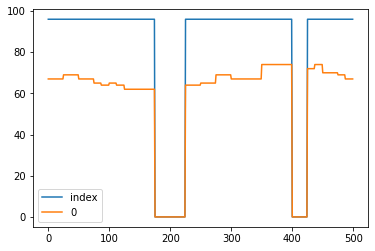

In [64]:
pd.DataFrame(y_pitch_train[0], y_velocity_train[0]).reset_index().plot()

In [70]:
X_train.shape

(254, 64000)

In [71]:
decision_tree_regressor = DecisionTreeRegressor()
X_train = X_train.reshape((254, 500 * 128))
decision_tree_regressor.fit(X_train, y_pitch_train)
y_pitch_pred = decision_tree_regressor.predict(X_test[1].reshape(1, -1))

decision_tree_regressor = DecisionTreeRegressor()
X_train = X_train.reshape((254, 500 * 128))
decision_tree_regressor.fit(X_train, y_velocity_train)
y_velocity_pred = decision_tree_regressor.predict(X_test[1].reshape(1, -1))

In [ ]:
y_velocity

<AxesSubplot:>

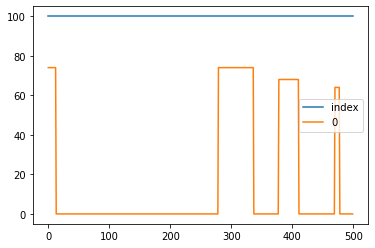

In [86]:
pd.DataFrame(y_pitch_pred.reshape(500,), y_velocity_pred.reshape(500, )).reset_index().plot()

In [54]:
decision_tree_regressor = DecisionTreeRegressor()

In [55]:
decision_tree_regressor.fit(X_train, y_velocity_train)

DecisionTreeRegressor()

In [57]:
y_velocity_pred = decision_tree_regressor.predict(X_test[2].reshape(1, -1))

In [58]:
y_velocity_pred

array([[100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 

In [58]:
# Let's listen to this
def melody_to_piano_roll(pitches, velocities):
    """
    Create a piano roll from a list of pitches and a list of velocities
    """
    piano_roll = np.zeros((128, pitches.shape[1]))
    
    for i, (pitch, velocity) in enumerate(zip(pitches[0], velocities[0])):
        if pitch > 0:
            piano_roll[int(pitch)][i] = velocity
            
    return piano_roll

In [59]:
melody = melody_to_piano_roll(y_pitch_pred, y_velocity_pred)

In [61]:
from MIDIComposingAI.utils import piano_roll_to_pretty_midi

In [62]:
pretty_melody = piano_roll_to_pretty_midi(melody, fs=50)

In [64]:
pretty_melody.write('melody_predicted.mid')

#### Test with tuple target (frames, (pitch, velocity))

In [3]:
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)

In [4]:
tree = DecisionTreeRegressor(max_leaf_nodes=2)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=2)

In [15]:
y_test.shape

(23, 500, 128, 2)

In [7]:
predictions = tree.predict(X_test.reshape(X_test.shape[0], -1))

In [22]:
predictions_reshaped = predictions.reshape(23, 128, 500, 2)

#### Test with two targets : IT WORKS WITH TWO TARGET ASSEMBLED (shape : (1, 1_000))

In [12]:
# I'll try to make it into a pipeline

In [8]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [9]:
y_train = np.array(
    [(pitch, velocity) for pitch, velocity in zip(y_pitch_train, y_velocity_train)]
)

In [10]:
y_train.shape

(254, 2, 500)

In [11]:
y_train = y_train.reshape(
    (
        y_train.shape[0], -1
    )
)

In [12]:
tree = DecisionTreeRegressor(random_state=2)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)

In [15]:
predicted_melodies = np.array([assembled_target_to_melody(prediction) for prediction in predictions])

In [22]:
X_test = X_test.reshape(-1, 128, 500)

In [10]:
for test in X_test:
    piano_roll_to_pretty_midi(test).write('file.mid')

ValueError: data byte must be in range 0..127

In [66]:
for test in X_test:
    if test.max() > 127:
        print(f'error : {test.max()}')

error : 200.0
error : 205.0
error : 240.0
error : 208.0
error : 200.0
error : 190.0
error : 240.0
error : 210.0
error : 247.0
error : 176.0
error : 194.0
error : 206.0
error : 181.0
error : 206.0
error : 247.0
error : 210.0
error : 164.0
error : 200.0
error : 240.0
error : 158.0
error : 201.0


In [61]:
for melody in predicted_melodies:
    if melody.max() > 127:
        print(f'error : {melody.max()}')

error : 240.0
error : 240.0
error : 240.0


In [34]:
assembled_music = np.array(
    [assemblate_accompaniment_melody(test, predicted_melody) for test, predicted_melody in zip(X_test, predicted_melodies)],
    dtype=np.int32
)

In [54]:
assembled_music[3].max()

205

In [62]:
predicted_music = [piano_roll_to_pretty_midi(music, fs=50)for music in assembled_music]

In [49]:
predicted_music[0].get_piano_roll().max()

200.0

In [ ]:
##### class_tree = DecisionTreeClassifier(random_state=2)

# melodies_classified_test = [create_classified_melody(melody) for melody in y_pitch_test]

# class_tree.fit(X_train, y_velocity_train.astype(np.int32))
# velocity_predict = class_tree.predict(X_test)

# pitches = [np.array(pitch) for pitch in pitch_predict]
# velocities = [np.array(velocity) for velocity in velocity_predict]

# Creating a DataFrame to compute a score
# df = pd.DataFrame(data=[pitches, velocities])
# df = df.T
# df.columns = ['pitches', 'velocities']

# Computing the score for each couple of predictions
# df['score'] = 0
# for sample in df.T:
#     for note, velocity in zip(df['pitches'][sample], df['velocities'][sample]):
#         if ((note > 0) and (velocity > 0)) or ((note == 0.) and (velocity == 0.)):
#             df['score'][sample] = df['score'][sample] + 1

# df['score'].mean()

In [7]:
# tree = DecisionTreeClassifier(max_leaf_nodes=2)
# multi_output = MultiOutputRegressor(tree).fit(X_train, y_train)

#### Two Models with feature enginering on pitches

In [3]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [4]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_pitch_train)
pitch_predicted = tree.predict(X_test)

In [6]:
# Now let's do the engineering
X_train = X_train.reshape((X_train.shape[0], 128, 500))
X_test = X_test.reshape((X_test.shape[0], 128, 500))

In [ ]:
for sample in X_train:
    

#### GridSearching best parameters

In [18]:
tree = DecisionTreeRegressor()
grid = {'min_samples_split' : [2, 3, 4, 5]}
search = GridSearchCV(tree, grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_pitch_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [20]:
search.best_params_, search.best_score_

({'min_samples_split': 5}, -0.4051499291821659)

In [40]:
# let's try best params
tree = DecisionTreeRegressor(min_samples_split=5)
tree.fit(X_train, y_pitch_train)

DecisionTreeRegressor(min_samples_split=5)

In [41]:
prediction = tree.predict(X_test[1].reshape(1, -1))

In [44]:
# Not very conclusive
prediction

array([[66.5, 66.5, 66.5, 66.5, 66.5, 66.5, 66.5, 66.5, 66.5, 66.5, 66.5,
        66.5, 66.5, 66.5, 66.5, 66.5, 66.5, 66.5, 66.5, 66.5, 66.5, 66.5,
        66.5, 66.5, 36.5, 36.5, 36.5, 36.5, 36.5, 36.5, 36.5, 36.5, 36.5,
        36.5, 36.5, 36.5, 36.5, 36.5, 36.5, 36.5, 36.5, 36.5, 36.5, 36.5,
        36.5, 36.5, 36.5, 36.5, 36.5, 36.5, 38.5, 38.5, 38.5, 38.5, 38.5,
        38.5, 38.5, 38.5, 38.5, 38.5, 38.5, 38.5, 68.5, 68.5, 68.5, 68.5,
        68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5,
        68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5,
        68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5,
        38.5, 29. , 29. , 29. , 29. , 29. , 29. , 29. , 29. , 29. , 29. ,
        29. , 29. , 29. , 29. , 29. , 29. , 29. , 29. , 29. , 29. , 29. ,
        29. , 29. , 29. , 29. , 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5,
        68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5, 68.5,
        68.5, 68.5, 68.5, 68.5, 68.5, 

In [45]:
# Let's keep the initial parameter and listen to the result

In [48]:
tree = DecisionTreeRegressor(min_samples_split=2)
tree.fit(X_train, y_pitch_train)
pitch_prediction = tree.predict(X_test[1].reshape(1, -1))

In [54]:
np.concatenate(X_train, y_pitch_train)

TypeError: only integer scalar arrays can be converted to a scalar index

In [49]:
# And for the velocity
tree = DecisionTreeRegressor(min_samples_split=2)
tree.fit(X_train, y_velocity_train)
velocity_prediction = tree.predict(X_test[1].reshape(1, -1))

In [51]:
pitch_prediction

array([[60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
        60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 60., 60., 60.,
        60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
        60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
        60., 60., 60., 60., 60., 60., 60., 60.,  0., 58., 58., 58., 58.,
        58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58.,
        58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58.,
        58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58.,
        58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58.,
        58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58., 58.,
        58., 58., 58., 58., 58., 58., 58., 58., 58.

In [50]:
velocity_prediction

array([[96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
        96., 96., 96., 96., 96., 96., 96., 96., 96.

### Random Forest
Not conclusive

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
X_train = X_train.reshape(X_train.shape[0], -1)

random_forest = RandomForestRegressor(n_estimators=5, criterion='poisson', verbose=3, n_jobs=-1)
random_forest.fit(X_train, y_pitch_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


KeyboardInterrupt: 

In [ ]:
random_forest.predict(X_test[1].reshape(1, -1))

In [ ]:
y_pitch_test[1]